In [10]:
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import numpy as np

# --- 1. CONFIGURATION AND DATA LOADING ---
# NOTE: The provided JSONL data needs to be saved to a file named 'ner_data.jsonl'
DATA_FILE = "datasets/ecommerce_ner_re_dataset.jsonl" 
# Using a fast, small, yet powerful model for generating sentence/token embeddings
EMBEDDING_MODEL_NAME = "all-MiniLM-L6-v2" 
N_NEIGHBORS = 15
MIN_DIST = 0.1
RANDOM_STATE = 42

## Load and extract entitites

Loads the JSONL dataset and extracts all entity texts with their labels.


In [11]:
print(f"Loading data from {DATA_FILE}...")
# Load dataset from the JSONL file
dataset = load_dataset("json", data_files=DATA_FILE, split="train")

entity_list = []
# Iterate through each sample (row) in the dataset
for item in dataset:
    text = item['text']
    # Iterate through the list of entities for the current text
    for entity in item['entities']:
        # Extract the actual text span for the entity using start/end indices
        entity_text = text[entity['start']:entity['end']]
        
        entity_list.append({
            'context': text,
            'text': entity_text,
            'label': entity['label']
        })

entity_df = pd.DataFrame(entity_list)

print(f"\nExtracted {len(entity_df)} entities with {len(entity_df['label'].unique())} unique labels.")


Loading data from datasets/ecommerce_ner_re_dataset.jsonl...

Extracted 9000 entities with 9 unique labels.


## Embeddings generation

Generates sentence embeddings for each extracted entity text.

In [14]:
print(f"Loading embedding model: {EMBEDDING_MODEL_NAME}...")
model = SentenceTransformer(EMBEDDING_MODEL_NAME)

print("Generating embeddings for all entities...")
# Generate embeddings (high-dimensional vectors) for the 'text' column
embeddings = model.encode(entity_df['context'].tolist(), show_progress_bar=True)
embeddings
    

Loading embedding model: all-MiniLM-L6-v2...
Generating embeddings for all entities...


Batches: 100%|██████████| 282/282 [01:16<00:00,  3.68it/s]


array([[-0.08495299,  0.00896699,  0.04806627, ..., -0.07699683,
        -0.00761835,  0.10514417],
       [-0.08495299,  0.00896699,  0.04806627, ..., -0.07699683,
        -0.00761835,  0.10514417],
       [-0.08495299,  0.00896699,  0.04806627, ..., -0.07699683,
        -0.00761835,  0.10514417],
       ...,
       [-0.08498774,  0.04555827,  0.02409378, ..., -0.0850785 ,
         0.00169928,  0.09679762],
       [-0.08498774,  0.04555827,  0.02409378, ..., -0.0850785 ,
         0.00169928,  0.09679762],
       [-0.08498774,  0.04555827,  0.02409378, ..., -0.0850785 ,
         0.00169928,  0.09679762]], dtype=float32)

## UMAP and visualization

Performs UMAP dimensionality reduction and creates the scatter plot.

/home/daniel/projects/git/organizations/data-science-adventure/huggingface-tutorial/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Performing UMAP reduction to 2D...
Generating UMAP visualization...


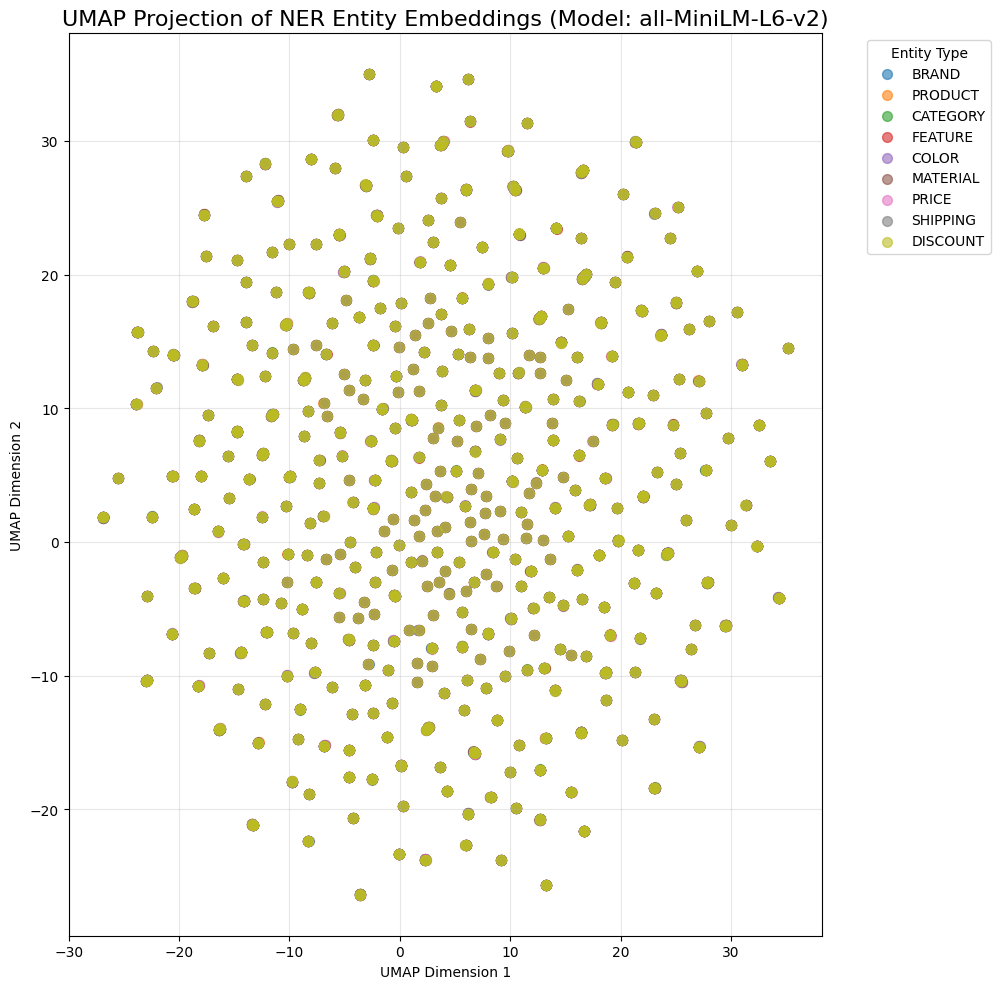

Visualization complete.


In [13]:
print(f"Performing UMAP reduction to 2D...")
reducer = umap.UMAP(
    n_neighbors=N_NEIGHBORS,
    min_dist=MIN_DIST,
    n_components=2,
    random_state=RANDOM_STATE
)
# Fit and transform the high-dimensional embeddings to 2D
embedding_2d = reducer.fit_transform(embeddings)

# Add the 2D coordinates to the DataFrame
entity_df['UMAP1'] = embedding_2d[:, 0]
entity_df['UMAP2'] = embedding_2d[:, 1]

# Visualization setup
plt.figure(figsize=(12, 10))

# Get all unique labels to use for coloring
labels = entity_df['label'].unique()

print("Generating UMAP visualization...")
for label in labels:
    subset = entity_df[entity_df['label'] == label]
    # Create a scatter plot, coloring points by their NER label
    plt.scatter(
        subset['UMAP1'],
        subset['UMAP2'],
        label=label,
        alpha=0.6,
        s=50 # size of the points
    )

plt.title(f'UMAP Projection of NER Entity Embeddings (Model: {EMBEDDING_MODEL_NAME})', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Entity Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for legend
plt.show()
print("Visualization complete.")